# RandomForest Regressor 

100%|██████████| 5961/5961 [00:01<00:00, 4893.94it/s]


Обучение моделей...


{'max_depth': 11, 'max_leaf_nodes': 500, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500} -0.1607354734039635

Результаты оценки моделей:

Оценка модели для k_1064:
MSE: 0.1564
R2 Score: 0.4560


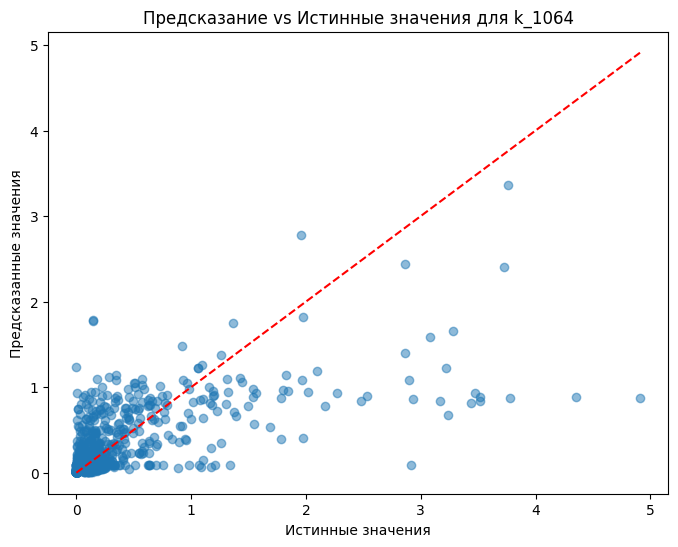


Важность признаков:


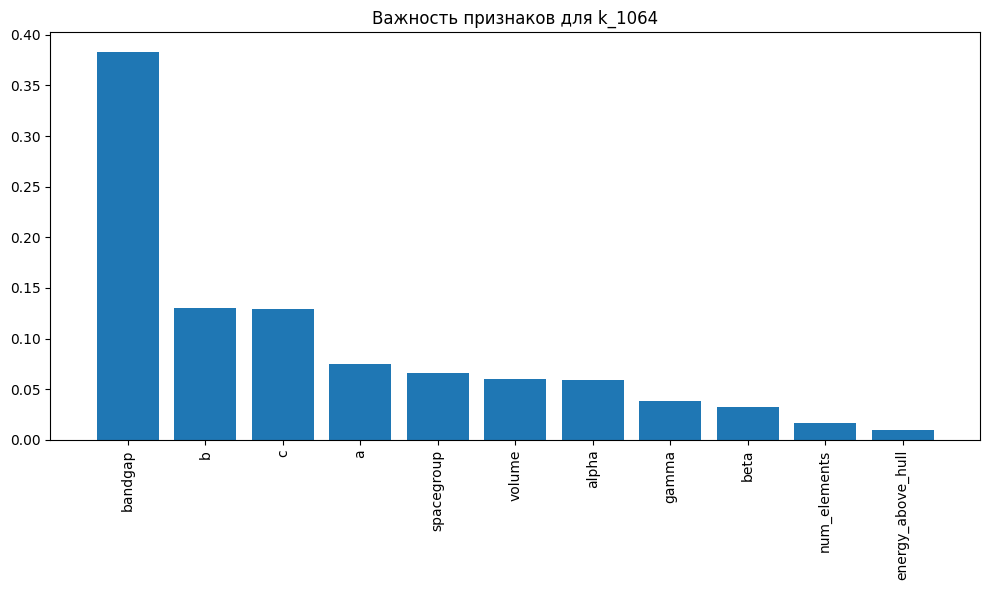

{'max_depth': 11, 'max_leaf_nodes': 500, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500} -0.21060844307482235

Результаты оценки моделей:

Оценка модели для k_755:
MSE: 0.1717
R2 Score: 0.5484


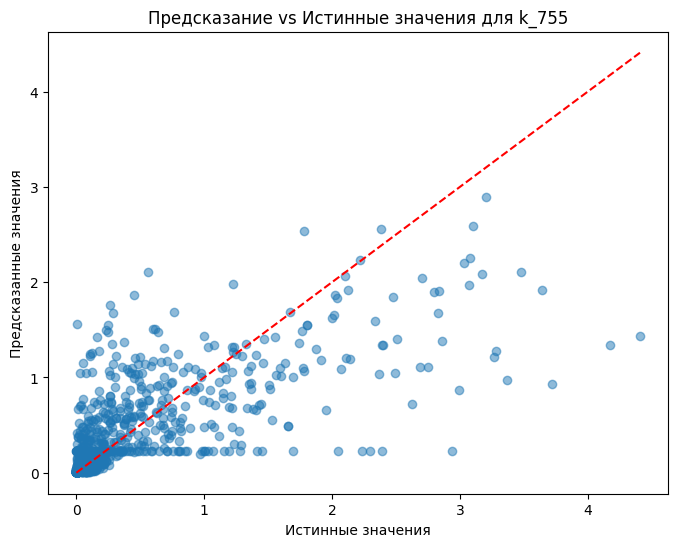


Важность признаков:


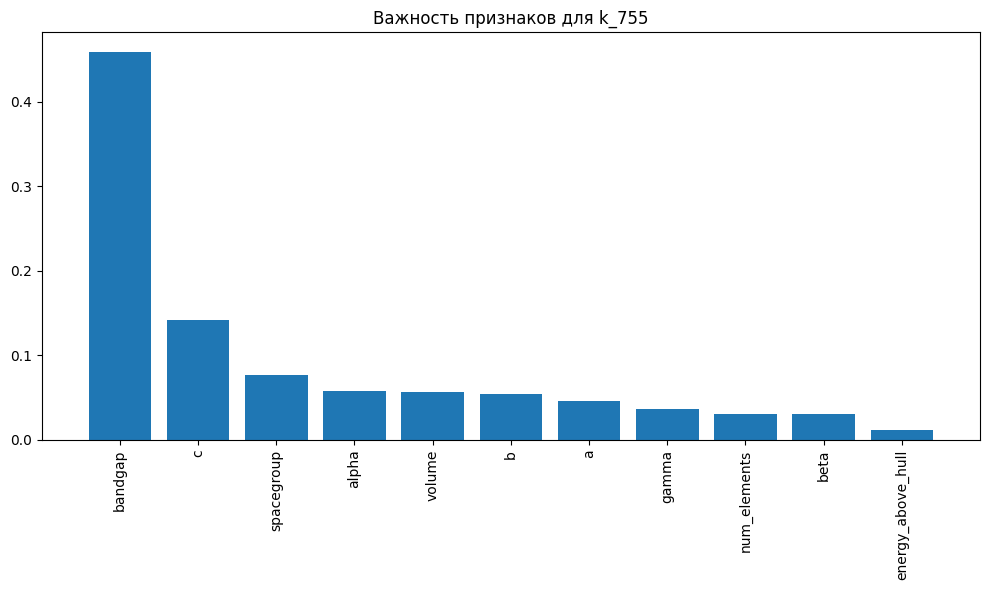

{'max_depth': 11, 'max_leaf_nodes': 250, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500} -0.19925332709743784

Результаты оценки моделей:

Оценка модели для k_1500:
MSE: 0.2217
R2 Score: 0.2984


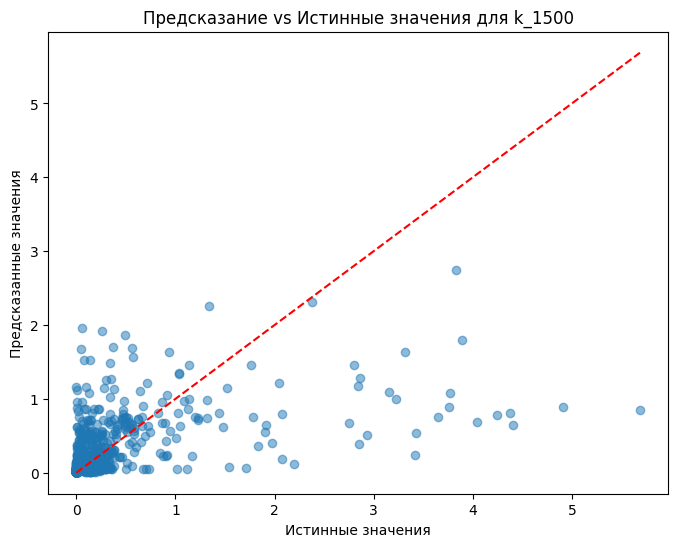


Важность признаков:


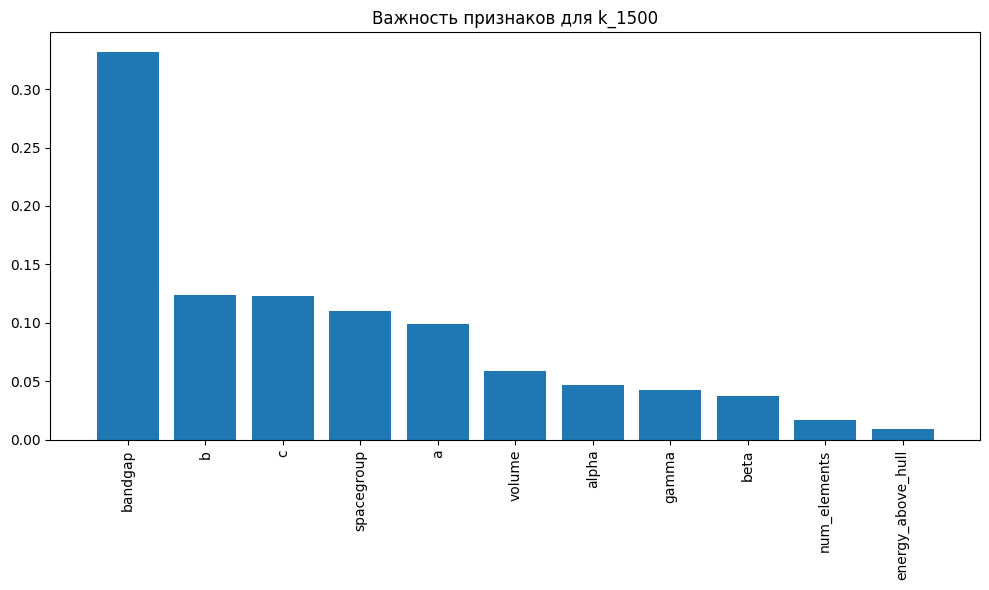

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
import json
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

data = pd.read_csv("full_mp+jv_5k_stable_bg_dataset.csv")

def prepare_data(data):
    data.fillna(0, inplace=True)

    features = []

    for idx, row in tqdm(data.iterrows(), total=len(data)):
        try:
            struct_dict = json.loads(row['structure_json'])
            lattice = struct_dict['lattice']

            volume = lattice['volume']
            a, b, c = lattice['a'], lattice['b'], lattice['c']
            alpha, beta, gamma = lattice['alpha'], lattice['beta'], lattice['gamma']

            formula = row['formula']
            num_elements = len(set([c for c in formula if c.isupper()]))

            features.append([
                volume, row['bandgap'], row['energy_above_hull'],
                a, b, c, alpha, beta, gamma,
                num_elements, row['spacegroup']
            ])
        except:
            features.append([0]*11)

    X = np.array(features)

    y_k1064 = data['k_1064'].values
    y_k755 = data['k_755'].values
    y_k1500 = data['k_1500'].values

    return X, y_k1064, y_k755, y_k1500

def plot_feature_importance(model, feature_names, target_name):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_title(f"Важность признаков для {target_name}")
    ax.bar(range(len(feature_names)), importances[indices], align="center")
    ax.set_xticks(range(len(feature_names)))
    ax.set_xticklabels([feature_names[i] for i in indices], rotation=90)
    ax.set_xlim([-1, len(feature_names)])
    plt.tight_layout()
    plt.show()
    return fig

feature_names = [
    'volume', 'bandgap', 'energy_above_hull',
    'a', 'b', 'c', 'alpha', 'beta', 'gamma',
    'num_elements', 'spacegroup'
]

def evaluate_model(model, X_test, y_test, target_name):
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\nОценка модели для {target_name}:")
    print(f"MSE: {mse:.4f}")
    print(f"R2 Score: {r2:.4f}")

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(y_test, y_pred, alpha=0.5)
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    ax.set_xlabel('Истинные значения')
    ax.set_ylabel('Предсказанные значения')
    plt.show()

    return fig

X, y_k1064, y_k755, y_k1500 = prepare_data(data)

X_train, X_test, y_train_1064, y_test_1064, y_train_755, y_test_755, y_train_1500, y_test_1500 = train_test_split(
    X, y_k1064, y_k755, y_k1500, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print()
print("Обучение моделей...")

params = {
    'n_estimators': [100, 500],
    'max_depth': [9, 11],
    'max_leaf_nodes': [250, 500],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [1, 2, 5],
}
# params = {
#     'n_estimators': [50, 100],
#     'max_depth': np.arange(6, 11, 4),
#     'max_leaf_nodes': [100,],
#     'min_samples_leaf': [3,],
#     'min_samples_split': [2,],
# }

rndf_reg = RandomForestRegressor(bootstrap=True, n_jobs=-1, random_state=42)
cv = 5

##########################################################

gs = GridSearchCV(rndf_reg, params, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)
gs.fit(X_train_scaled, y_train_1064)

print(gs.best_params_, gs.best_score_)

print("\nРезультаты оценки моделей:")
fig_1064 = evaluate_model(gs.best_estimator_, X_test_scaled, y_test_1064, "k_1064")

print("\nВажность признаков:")
fig_imp_1064 = plot_feature_importance(gs.best_estimator_, feature_names, "k_1064")

##########################################################

gs = GridSearchCV(rndf_reg, params, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)
gs.fit(X_train_scaled, y_train_755)

print(gs.best_params_, gs.best_score_)

print("\nРезультаты оценки моделей:")
fig_755 = evaluate_model(gs.best_estimator_, X_test_scaled, y_test_755, "k_755")

print("\nВажность признаков:")
fig_imp_755 = plot_feature_importance(gs.best_estimator_, feature_names, "k_755")

##########################################################

gs = GridSearchCV(rndf_reg, params, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)
gs.fit(X_train_scaled, y_train_1500)

print(gs.best_params_, gs.best_score_)

print("\nРезультаты оценки моделей:")
fig_1500 = evaluate_model(gs.best_estimator_, X_test_scaled, y_test_1500, "k_1500")

print("\nВажность признаков:")
fig_imp_1500 = plot_feature_importance(gs.best_estimator_, feature_names, "k_1500")